In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

# Завантаження даних
transform = transforms.Compose(
    [
        torchvision.transforms.Grayscale(num_output_channels=3),
        transforms.RandomResizedCrop(224),
        transforms.ToTensor()])

trainset = torchvision.datasets.FashionMNIST(root='./fashion-mnist', train=True,
                                             download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)


testset = torchvision.datasets.FashionMNIST(root='./fashion-mnist', train=False,
                                            download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./fashion-mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./fashion-mnist/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./fashion-mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./fashion-mnist/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./fashion-mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./fashion-mnist/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./fashion-mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./fashion-mnist/FashionMNIST/raw



In [3]:
from torchvision.models import VGG16_Weights
from torch.optim import lr_scheduler, SGD
import torchvision.models as models
import torch
from torch import nn

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model_ft = models.vgg16(weights=VGG16_Weights.DEFAULT).requires_grad_(True)

if torch.cuda.is_available():
    model_ft.to(device)

num_ftrs = model_ft.classifier[-1].in_features
model_ft.classifier[-1] = nn.Linear(num_ftrs, len(classes))

criterion = nn.CrossEntropyLoss()
optimizer_ft = SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)



Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [4]:
model_ft.classifier.requires_grad_(True)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)

In [5]:
device

device(type='cuda')

In [6]:
def save_to_drive(model):
  torch.save({"state": model.state_dict()}, "/content/gdrive/MyDrive/vgg16_fine_tuned_state.pt")

In [7]:
import copy
from tqdm.notebook import tqdm

def validate_model(model):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    data_size = len(testloader.dataset)
    for inputs, labels in tqdm(testloader, leave=False, total=data_size//testloader.batch_size + 1):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / data_size
    epoch_acc = running_corrects.double() / data_size
    print('{} Loss: {:.4f} Acc: {:.4f}'.format("Validation", epoch_loss, epoch_acc))
    return epoch_acc




def train_model(model, criterion, optimizer, scheduler, num_epochs=15):
    best_model_wts = copy.deepcopy(model.state_dict())
    highest_score = 0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase


        model.train()
        model.to(device)

        running_loss = 0.0
        running_corrects = 0

        data_size = len(trainloader.dataset)
        for inputs, labels in tqdm(trainloader, leave=False, total=data_size//trainloader.batch_size + 1):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()
           
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        scheduler.step()
        epoch_loss = running_loss / data_size
        epoch_acc = running_corrects.double() / data_size
        print('{} Loss: {:.4f} Acc: {:.4f}'.format('Traning', epoch_loss, epoch_acc))
        

        epoch_acc = validate_model(model)


        if highest_score < epoch_acc:
          highest_score = epoch_acc
          best_model_wts = copy.deepcopy(model.state_dict())
          save_to_drive(model)
          print("best model updated")

          
    model.load_state_dict(best_model_wts)
    return model


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------


  0%|          | 0/938 [00:00<?, ?it/s]

Traning Loss: 0.8098 Acc: 0.7041


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.6308 Acc: 0.7693
best model updated
Epoch 1/19
----------


  0%|          | 0/938 [00:00<?, ?it/s]

Traning Loss: 0.6010 Acc: 0.7816


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.5792 Acc: 0.7876
best model updated
Epoch 2/19
----------


  0%|          | 0/938 [00:00<?, ?it/s]

Traning Loss: 0.5459 Acc: 0.8027


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.5734 Acc: 0.7879
best model updated
Epoch 3/19
----------


  0%|          | 0/938 [00:00<?, ?it/s]

Traning Loss: 0.5237 Acc: 0.8084


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.4967 Acc: 0.8158
best model updated
Epoch 4/19
----------


  0%|          | 0/938 [00:00<?, ?it/s]

Traning Loss: 0.5023 Acc: 0.8190


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.4719 Acc: 0.8290
best model updated
Epoch 5/19
----------


  0%|          | 0/938 [00:00<?, ?it/s]

In [ ]:
model_ft.load_state_dict(torch.load("/content/gdrive/MyDrive/vgg16_fine_tuned_state.pt")["state"])

<All keys matched successfully>

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------


  0%|          | 0/938 [00:00<?, ?it/s]

Traning Loss: 0.4800 Acc: 0.8253


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.4764 Acc: 0.8245
best model updated
Epoch 1/9
----------


  0%|          | 0/938 [00:00<?, ?it/s]

Traning Loss: 0.4665 Acc: 0.8287


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.4888 Acc: 0.8199
Epoch 2/9
----------


  0%|          | 0/938 [00:00<?, ?it/s]

Traning Loss: 0.4522 Acc: 0.8347


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.4340 Acc: 0.8392
best model updated
Epoch 3/9
----------


  0%|          | 0/938 [00:00<?, ?it/s]

Traning Loss: 0.4409 Acc: 0.8392


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.4388 Acc: 0.8397
best model updated
Epoch 4/9
----------


  0%|          | 0/938 [00:00<?, ?it/s]

Traning Loss: 0.4250 Acc: 0.8451


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.4375 Acc: 0.8448
best model updated
Epoch 5/9
----------


  0%|          | 0/938 [00:00<?, ?it/s]

Traning Loss: 0.4222 Acc: 0.8458


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.4499 Acc: 0.8377
Epoch 6/9
----------


  0%|          | 0/938 [00:00<?, ?it/s]

Traning Loss: 0.4163 Acc: 0.8485


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.4464 Acc: 0.8389
Epoch 7/9
----------


  0%|          | 0/938 [00:00<?, ?it/s]

Traning Loss: 0.3787 Acc: 0.8605


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.3821 Acc: 0.8614
best model updated
Epoch 8/9
----------


  0%|          | 0/938 [00:00<?, ?it/s]

Traning Loss: 0.3704 Acc: 0.8637


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.3905 Acc: 0.8589
Epoch 9/9
----------


  0%|          | 0/938 [00:00<?, ?it/s]

Traning Loss: 0.3672 Acc: 0.8654


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.3847 Acc: 0.8628
best model updated


In [13]:
model_ft.load_state_dict(torch.load("/content/gdrive/MyDrive/vgg16_fine_tuned_state.pt")["state"])
model_ft = model_ft.to(device)

In [14]:
_ = validate_model(model_ft)

  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.3833 Acc: 0.8575


# SiameseNetwork

In [15]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = model_ft.requires_grad_(False).to(device)
        self.fc1 = nn.Linear(model_ft.classifier[-1].out_features*2, 16)
        self.fc2 = nn.Linear(16, 1)



    def forward(self, input1, input2):#did not know how to let two resnet share the same param.
        output1 = self.cnn1(input1)
        output1 = output1.view(output1.size()[0], -1)#make it suitable for fc layer.
        output2 = self.cnn1(input2)
        output2 = output2.view(output2.size()[0], -1)
        
        output = torch.cat((torch.softmax(output1, dim=-1), 
                            torch.softmax(output2, dim=-1)), 1).to(device)
        output = torch.relu(self.fc1(output))
        output = torch.relu(self.fc2(output))
        return torch.Tensor(torch.sigmoid(output))


In [16]:
siamese_nn = SiameseNetwork().to(device)

In [17]:
import matplotlib.pyplot as plt
import numpy as np

In [18]:
def gen_random_batch(data_source, batch_halfsize = 8):
    class_id = np.random.randint(0, len(classes))
    class_mask = data_source.targets == class_id

    main_class_image_idx = np.random.choice(np.where(data_source.targets == class_id)[0], size=batch_halfsize*3)
    side_class_image_idx = np.random.choice(np.where(data_source.targets != class_id)[0], size=batch_halfsize)

    out_img_a = [data_source[idx][0] for idx in main_class_image_idx[:batch_halfsize*2]]
    out_img_b = [data_source[idx][0] for idx in main_class_image_idx[-batch_halfsize:]] + \
                          [data_source[idx][0] for idx in side_class_image_idx]

    out_score = [1] * batch_halfsize + [0] * batch_halfsize
    return out_img_a, out_img_b, out_score

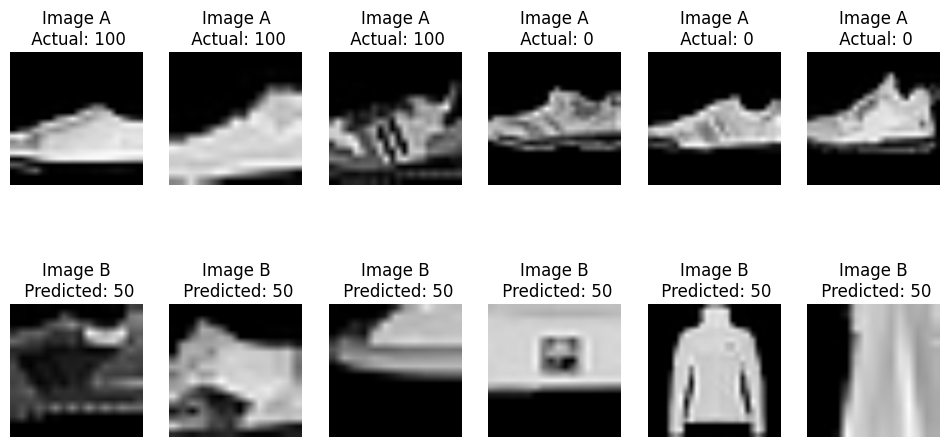

In [19]:
def show_model_output(nb_examples = 3):
    pv_a, pv_b, pv_sim = gen_random_batch(testset, nb_examples)
    pred_sim = siamese_nn(torch.stack(pv_a).to(device), torch.stack(pv_b).to(device))
    fig, m_axs = plt.subplots(2, len(pv_a), figsize = (12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a.permute(1, 2, 0))
        ax1.set_title(f'Image A\n Actual: { 100 * c_d }')
        ax1.axis('off')
        ax2.imshow(c_b.permute(1, 2, 0))
        ax2.set_title(f'Image B\n Predicted: {int( 100 * p_d[0] )}')
        ax2.axis('off')
    return fig
# a completely untrained model
_ = show_model_output()

In [ ]:
siamese_nn.eval()

SiameseNetwork(
  (cnn1): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      

In [ ]:
num_epochs = 20
batch_size = 64
n_batches = 500

criterion = nn.BCELoss(reduction='sum')
optimizer = torch.optim.Adam(siamese_nn.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


best_acc = 0

for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      print('-' * 10)
      # Each epoch has a training and validation phase


      siamese_nn.train()
      siamese_nn.to(device)

      running_loss = 0.0
      running_corrects = 0

      data_size = n_batches*batch_size
      for a, b, labels in tqdm((gen_random_batch(trainset, batch_size//2) for _ in range(n_batches)), leave=False, total=n_batches):
          labels = torch.Tensor(labels).to(device)
          optimizer.zero_grad()

          with torch.set_grad_enabled(True):
              outputs = siamese_nn(torch.stack(a).to(device), torch.stack(b).to(device))
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels.view(len(labels), -1))

              loss.backward()
              optimizer.step()
              
          
          running_loss += loss.item() * len(a)
          running_corrects += torch.sum((preds > 0.5) == labels)

      scheduler.step()
      epoch_loss = running_loss / data_size
      epoch_acc = running_corrects.double() / data_size
      print('{} Loss: {:.4f} Acc: {:.4f}'.format('Traning', epoch_loss, epoch_acc))
      

Epoch 0/19
----------


  0%|          | 0/500 [00:00<?, ?it/s]

Updated
Traning Loss: 44.3614 Acc: 0.5000
Epoch 1/19
----------


  0%|          | 0/500 [00:00<?, ?it/s]

Traning Loss: 41.8421 Acc: 0.5602
Epoch 2/19
----------


  0%|          | 0/500 [00:00<?, ?it/s]

Traning Loss: 39.4562 Acc: 0.6317
Epoch 3/19
----------


  0%|          | 0/500 [00:00<?, ?it/s]

Traning Loss: 38.8911 Acc: 0.6623
Epoch 4/19
----------


  0%|          | 0/500 [00:00<?, ?it/s]

Traning Loss: 36.1926 Acc: 0.6815
Epoch 5/19
----------


  0%|          | 0/500 [00:00<?, ?it/s]

Traning Loss: 32.4872 Acc: 0.7198
Epoch 6/19
----------


  0%|          | 0/500 [00:00<?, ?it/s]

Traning Loss: 31.7783 Acc: 0.7384
Epoch 7/19
----------


  0%|          | 0/500 [00:00<?, ?it/s]

Traning Loss: 29.8953 Acc: 0.7402
Epoch 8/19
----------


  0%|          | 0/500 [00:00<?, ?it/s]

Traning Loss: 28.1937 Acc: 0.7522
Epoch 9/19
----------


  0%|          | 0/500 [00:00<?, ?it/s]

Traning Loss: 27.7384 Acc: 0.7498
Epoch 10/19
----------


  0%|          | 0/500 [00:00<?, ?it/s]

Traning Loss: 27.1483 Acc: 0.7602
Epoch 11/19
----------


  0%|          | 0/500 [00:00<?, ?it/s]

Traning Loss: 26.5649 Acc: 0.7663
Epoch 12/19
----------


  0%|          | 0/500 [00:00<?, ?it/s]

Traning Loss: 25.8940 Acc: 0.7701
Epoch 13/19
----------


  0%|          | 0/500 [00:00<?, ?it/s]

Traning Loss: 25.1028 Acc: 0.7748
Epoch 14/19
----------


  0%|          | 0/500 [00:00<?, ?it/s]

Traning Loss: 24.8192 Acc: 0.7781
Epoch 15/19
----------


  0%|          | 0/500 [00:00<?, ?it/s]

Traning Loss: 24.5293 Acc: 0.7817
Epoch 16/19
----------


  0%|          | 0/500 [00:00<?, ?it/s]

Traning Loss: 24.2012 Acc: 0.7842
Epoch 17/19
----------


  0%|          | 0/500 [00:00<?, ?it/s]

Traning Loss: 23.9648 Acc: 0.7862
Epoch 18/19
----------


  0%|          | 0/500 [00:00<?, ?it/s]

Traning Loss: 23.7937 Acc: 0.7883


  0%|          | 0/500 [00:00<?, ?it/s]

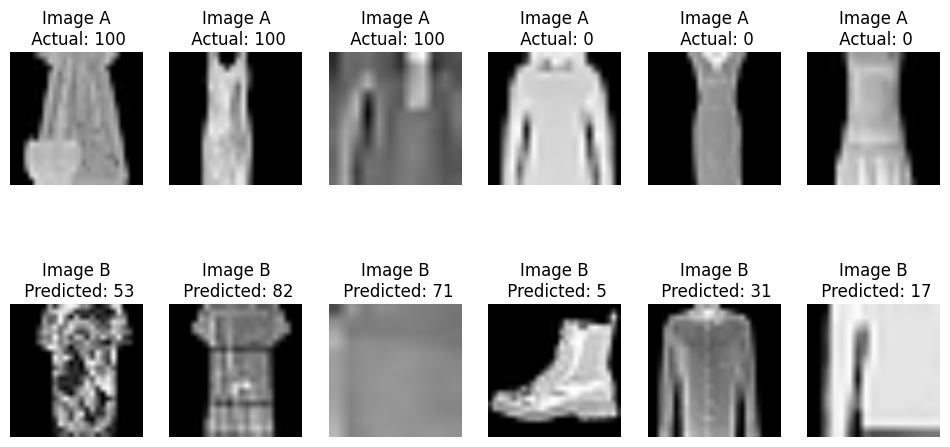

In [25]:
_ = show_model_output()

#  TSNE

In [ ]:
x_test_features = []
test_Y = []

model_ft.to(device)
for input, output in testloader:
    x_test_features.extend(model_ft(input.to(device)).cpu().detach().numpy())
    test_Y.extend(output.numpy())

x_test_features = np.array(x_test_features)
test_Y = np.array(test_Y)

<ipython-input-25-c68e10d44ef7>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  x_test_features = torch.Tensor(x_test_features)


In [ ]:
from sklearn.manifold import TSNE


tsne_obj = TSNE(n_components=2,
    init='pca',
    random_state=1,
    method='barnes_hut',
    n_iter=2000,
    verbose=1)
tsne_features = tsne_obj.fit_transform(x_test_features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.024s...
[t-SNE] Computed neighbors for 10000 samples in 1.082s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.450495
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.197723
[t-SNE] KL divergence after 2000 iterations: 1.496198


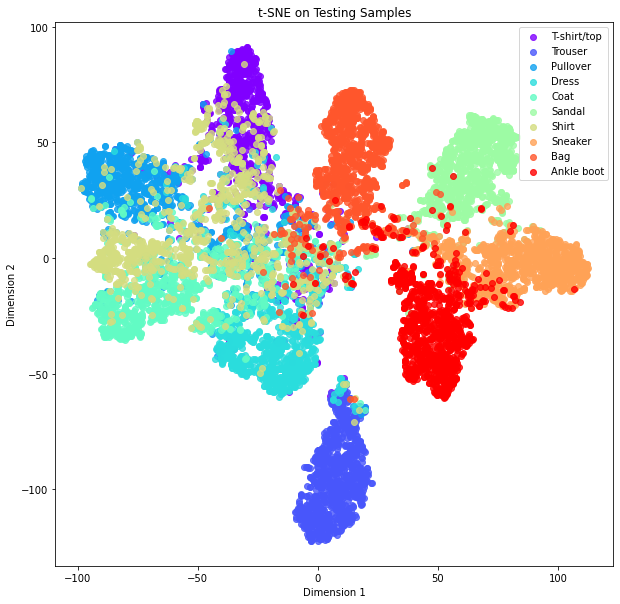

In [ ]:
obj_categories = classes
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(tsne_features[np.where(test_Y == c_group), 0],
        tsne_features[np.where(test_Y == c_group), 1],
        marker='o',
        color=c_color,
        linewidth=1,
        alpha=0.8,
        label=c_label)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)